In [ ]:
import torch

print(torch.cuda.is_available())

True


# **Data Exploration**

In [ ]:
import pandas as pd

wine_df = pd.read_csv('/kaggle/input/wine-reviews-dataset-first-150k/winemag-data_first150k.csv')
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [ ]:
wine_df.isna().sum()

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [ ]:
wine_df = wine_df[['description', 'variety']]
wine_df = wine_df.dropna()
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  150930 non-null  object
 1   variety      150930 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


# **Data Preprocessing**

In [ ]:
temp_df = wine_df['variety'].value_counts()
top4 = temp_df.index[:4]
print(top4)

Index(['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend'], dtype='object', name='variety')


In [ ]:
wine_df = wine_df[wine_df['variety'].isin(top4)]

<Axes: xlabel='variety', ylabel='count'>

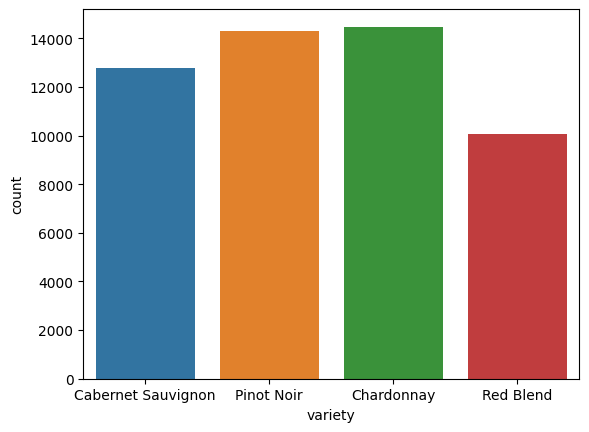

In [ ]:
# Count plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(wine_df, x='variety')

In [ ]:
cabernet_sauvignon_df = wine_df[wine_df['variety'] == 'Cabernet Sauvignon']
pinot_noir_df = wine_df[wine_df['variety'] == 'Pinot Noir']
chardonnay_df = wine_df[wine_df['variety'] == 'Chardonnay']
red_blend_df = wine_df[wine_df['variety'] == 'Red Blend']

In [ ]:
cabernet_sauvignon_df = cabernet_sauvignon_df.sample(n=len(red_blend_df), random_state=42)
pinot_noir_df = pinot_noir_df.sample(n=len(red_blend_df), random_state=42)
chardonnay_df = chardonnay_df.sample(n=len(red_blend_df), random_state=42)

<Axes: xlabel='variety', ylabel='count'>

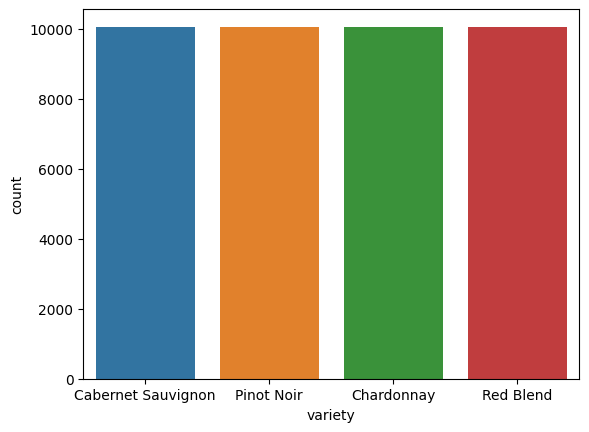

In [ ]:
wine_df = pd.concat([cabernet_sauvignon_df, pinot_noir_df, chardonnay_df, red_blend_df])

sns.countplot(wine_df, x='variety')

# **Data Target Class Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(wine_df['variety'])

wine_df['variety'] = label_encoder.transform(wine_df['variety'])
print(len(label_encoder.classes_))

4


# **Data Splitting (Train, Validation, Test)**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    wine_df['description'],
    wine_df['variety'],
    test_size=0.2,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42
)

wine_train_df = pd.DataFrame({'description': X_train, 'variety': y_train})
wine_val_df = pd.DataFrame({'description': X_val, 'variety': y_val})
wine_test_df = pd.DataFrame({'description': X_test, 'variety': y_test})

# **Creating the Classifier Model**

In [ ]:
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertModel

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

max_length_from_data = np.max([wine_train_df['description'].apply(len).max(), wine_test_df['description'].apply(len).max()])

In [ ]:
import torch.nn as nn

class WineVarietyClassifier(nn.Module):
    def __init__(self, n_classes):
        super(WineVarietyClassifier, self).__init__()
        self.distilbert = distilbert
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(distilbert.config.hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.hidden_linear = nn.Linear(distilbert.config.hidden_size, 128)
        self.classifier = nn.Linear(128, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        outputs = outputs.last_hidden_state[:, 0, :]
        outputs = self.batch_norm1(outputs)
        outputs = self.dropout1(outputs)
        outputs = self.hidden_linear(outputs)
        outputs = self.batch_norm2(outputs)
        outputs = self.dropout2(outputs)
        outputs = self.classifier(outputs)
        outputs = self.softmax(outputs)
        return outputs

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

n_classes = len(label_encoder.classes_)
model = WineVarietyClassifier(n_classes)
model = model.to(device)

# **Creating Custom Wine Dataset for Pytorch**

In [ ]:
from torch.utils.data import Dataset

class CustomWineDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        description = self.dataframe['description'].iloc[idx]

        inputs = self.tokenizer(
            description,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_length if self.max_length < 512 else 512,
            padding='max_length'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'variety': torch.tensor(self.dataframe['variety'].iloc[idx], dtype=torch.long)
        }

In [ ]:
wine_train_dataset = CustomWineDataset(wine_train_df, tokenizer, max_length_from_data)
wine_val_dataset = CustomWineDataset(wine_val_df, tokenizer, max_length_from_data)
wine_test_dataset = CustomWineDataset(wine_test_df, tokenizer, max_length_from_data)

# **Set Hyperparameters, Loss, and Optimizer Functions**

In [ ]:
learning_rate = 1e-5
batch_size = 16
epochs = 10

**Create Dataloaders for dataset**

In [ ]:
from torch.utils.data import DataLoader

wine_train_dataloader = DataLoader(wine_train_dataset, batch_size=batch_size, shuffle=True)
wine_val_dataloader = DataLoader(wine_val_dataset, batch_size=batch_size, shuffle=False)
wine_test_dataloader = DataLoader(wine_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **Define Train, Validation, and Test Loop**

In [ ]:
def train_loop(dataloader, model: WineVarietyClassifier, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, data in enumerate(dataloader):
        input_ids = data['input_ids']
        input_ids = input_ids.to(device)

        attention_mask = data['attention_mask']
        attention_mask = attention_mask.to(device)

        variety = data['variety']
        variety = variety.to(device)

        # Compute prediction and loss
        pred = model(input_ids, attention_mask)
        loss = loss_fn(pred, variety)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(input_ids)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids']
            input_ids = input_ids.to(device)

            attention_mask = data['attention_mask']
            attention_mask = attention_mask.to(device)

            variety = data['variety']
            variety = variety.to(device)

            pred = model(input_ids, attention_mask)
            val_loss += loss_fn(pred, variety).item()
            correct += (pred.argmax(1) == variety).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Validation Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

# **Training the model**

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(wine_train_dataloader, model, loss_fn, optimizer)
    val_loop(wine_val_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 1.378436  [   16/32198]
loss: 1.362466  [ 1616/32198]
loss: 1.061935  [ 3216/32198]
loss: 1.042823  [ 4816/32198]
loss: 0.907935  [ 6416/32198]
loss: 0.936212  [ 8016/32198]
loss: 0.801385  [ 9616/32198]
loss: 0.906141  [11216/32198]
loss: 0.819512  [12816/32198]
loss: 0.902911  [14416/32198]
loss: 0.918661  [16016/32198]
loss: 0.974886  [17616/32198]
loss: 0.876030  [19216/32198]
loss: 0.958255  [20816/32198]
loss: 0.900768  [22416/32198]
loss: 0.774633  [24016/32198]
loss: 0.816566  [25616/32198]
loss: 1.050287  [27216/32198]
loss: 0.922513  [28816/32198]
loss: 0.841473  [30416/32198]
loss: 0.786434  [32016/32198]
Validation Error: 
Accuracy: 88.0%, Avg loss: 0.863648 

Epoch 2
-------------------------------
loss: 0.813495  [   16/32198]
loss: 0.764240  [ 1616/32198]
loss: 0.925380  [ 3216/32198]
loss: 0.887637  [ 4816/32198]
loss: 0.757571  [ 6416/32198]
loss: 0.835974  [ 8016/32198]
loss: 0.830089  [ 9616/32198]
loss: 0.781599  [11216/

In [ ]:
def test_loop(dataloader, model):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()

    # Lists to store predictions and actual values
    y_pred = []
    y_true = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            variety = data['variety'].to(device)

            # Make predictions
            outputs = model(input_ids, attention_mask)

            # Get the predicted class (argmax of the output)
            predictions = outputs.argmax(dim=1)

            # Append predictions and actual values to the lists
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(variety.cpu().numpy())

    return y_pred, y_true

# **Testing and Evaluation**

In [ ]:
y_pred, y_true = test_loop(wine_test_dataloader, model)

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[926   1  27  73]
 [ 14 977   4   2]
 [ 93   5 872  32]
 [ 99   4  21 875]]


In [ ]:
from sklearn.metrics import classification_report

target_names = label_encoder.inverse_transform(range(4))
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.82      0.90      0.86      1027
        Chardonnay       0.99      0.98      0.98       997
        Pinot Noir       0.94      0.87      0.91      1002
         Red Blend       0.89      0.88      0.88       999

          accuracy                           0.91      4025
         macro avg       0.91      0.91      0.91      4025
      weighted avg       0.91      0.91      0.91      4025

